# Normally Distributed Risk Factors

This analysis replicates the study by Feng et al. (2022), utilizing normally distributed risk factors to estimate optimal fair cash allocations through deep learning, aiming to optimize the multivariate systemic risk measure.

In [1]:
# Import necessary libraries
import time
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split

np.random.seed(123) # Seed for NumPy's random number generator
random.seed(123) # Seed for Python's random number generator

mpl.rcParams['font.family'] = 'serif' # Set the default font family to 'serif' in Matplotlib
mpl.rcParams['font.serif'] = ['Times New Roman'] # Set the specific serif font to 'Times New Roman' in Matplotlib
plt.rcParams.update({'font.size': 14}) # Update the font size for all text elements in Matplotlib to 14

## Data preparation

In [2]:
# Load the training and test data
X_train = tf.constant(np.load('sim_data/X_norm_train.npy'), dtype=tf.float32)
X_test = tf.constant(np.load('sim_data/X_norm_test.npy'), dtype=tf.float32)

### Set constants and hyperparameters

In [3]:
N = 10  # The number of financial institutions (dimension of the risk vector)
num_samples = 50000  # Number of samples to generate and use for training
epochs = 1000  # Number of training epochs
layers = 2  # Number of layers in the neural network
batch_size = 1024  # Size of each batch for training
B = tf.constant(-1, dtype=tf.float32)  # Define a constant B with a value less than 0

model_shape = [None, N]  # Shape for the main input (None for batch size, N for features)
hidden_shape = 64  # Number of neurons in the hidden layer

alpha_n = [1.11, 1.20, 1.36, 1.89, 1.94, 2.04, 2.27, 2.33, 2.63, 2.99] # Define a list of alpha values
alpha_n = tf.constant(alpha_n, dtype=tf.float32)  # Convert the list of alpha values to a TensorFlow constant

In [4]:
alpha_n_res_out = pd.DataFrame({'Alpha_n': alpha_n.numpy()}).transpose()  # Create a DataFrame from the alpha_n values, setting 'Alpha_n' as the column name and then transpose it
alpha_n_res_out.columns = alpha_n_res_out.columns + 1 # Adjust the column names by incrementing each column index by 1
alpha_n_res_out.to_csv('out/alpha_n_res.csv', index=True) # Save the DataFrame to a CSV file, including the index
alpha_n_res_out # Display the DataFrame

,1,2,3,4,5,6,7,8,9,10
Alpha_n,1.11,1.2,1.36,1.89,1.94,2.04,2.27,2.33,2.63,2.99


### Define theoretical solutions

In [5]:
# Define exponential utility functions
def exponential_utility_tf(x, alpha):
    return -tf.exp(-alpha * x)/alpha

In [6]:
# Define rn_derivative as the theoretical solution to the dual problem
def rn_deriv_dual_problem(X, alpha_n):
    beta = tf.math.reduce_sum(tf.divide(1, alpha_n), axis=-1)
    S = tf.math.reduce_sum(X, axis=-1, keepdims=True)
    rn_derivative = tf.divide(tf.exp(-tf.divide(S, beta)), tf.reduce_mean(tf.exp(-tf.divide(S, beta)), axis=0, keepdims=True))
    return rn_derivative

# Define y as the theoretical solution to the primal problem
def y_dual_problem(X, alpha_n, B):
    beta = tf.math.reduce_sum(tf.divide(1, alpha_n), axis=-1)
    S = tf.math.reduce_sum(X, axis=-1, keepdims=True)
    rho = beta * tf.math.log(-tf.divide(beta, B) * tf.reduce_mean(tf.exp(-tf.divide(S, beta)), axis=0, keepdims=False))
    Y = -X + tf.divide(1, beta*alpha_n) * S + tf.divide(1, beta*alpha_n) * rho
    return Y
    
# Define theoretical rho as the objective function in the dual problem
def rho_dual_problem(X, alpha_n, B):
    beta = tf.math.reduce_sum(tf.divide(1, alpha_n), axis=-1)
    S = tf.math.reduce_sum(X, axis=-1, keepdims=True)
    rho = beta * tf.math.log(-tf.divide(beta, B) * tf.reduce_mean(tf.exp(-tf.divide(S, beta)), axis=0, keepdims=False))
    return rho

# Define theoretical alpha_B as the objective function in the dual problem
def alpha_B_dual_problem(X, alpha_n, B):
    beta = tf.math.reduce_sum(tf.divide(1, alpha_n), axis=-1)
    S = tf.math.reduce_sum(X, axis=-1, keepdims=True)
    rn_derivative = tf.divide(tf.exp(-tf.divide(S, beta)), tf.reduce_mean(tf.exp(-tf.divide(S, beta)), axis=0, keepdims=False))
    alpha_B = beta * tf.reduce_mean(rn_derivative * tf.math.log(rn_derivative), axis=0, keepdims=False) + beta * tf.math.log(-tf.divide(B, beta))
    return alpha_B

In [7]:
# Define response training and test data for comparison with the estimated solution
y_train = y_dual_problem(X_train, alpha_n, B)
y_test = y_dual_problem(X_test, alpha_n, B)

dQ_dP_train_theo = rn_deriv_dual_problem(X_train, alpha_n)
dQ_dP_test_theo = rn_deriv_dual_problem(X_test, alpha_n)

## Dual problem

Objective function for the deep learning task specified by Feng et al. (2022):
$$
J_{\text{dual}}(\Psi, \Theta) := \sum_{n=1}^{N} \mathbb{E}[-X^n \cdot \Theta(\mathbf{X})] - \tilde \alpha_B(\Psi, \Theta)
$$
with the objective funcitons:
$$
\tilde \rho = \sup_{w_\theta, b_\theta} J_{\text{dual}}(\Psi,\Theta)
$$
$$
\tilde \alpha_B(\Psi, \Theta) = \sup_{w_\psi, b_\psi} J_\alpha(\Psi, \Theta)
$$
with 
$$
J_\alpha(\Psi, \Theta) = \sum_{n=1}^{N} \mathbb{E}[-\Psi^n \cdot \Theta(\mathbf{X})] - \lambda_\alpha(B - \sum_{n=1}^N \mathbb{E}[u_n(\mathbf{X})])^+
$$
where $\Theta: \mathbb{R}^N \rightarrow \mathbb{R}$ represent the Radon-Nikodym derivative $\frac{dQ}{d\mathbb{P}}$ parameterized by ($w_\theta$, $b_\theta$), $\Psi: \mathbb{R}^N \rightarrow \mathbb{R}^N$, parameterized by($w\psi$, $b_\psi$), is used to generate random variables $\mathbf{Z}:=(Z^1,\dots,Z^N)=(\Psi_1(\mathbf{X}),\dots, \Psi_N(\mathbf{X}))=:\Psi(\mathbf{X})$.

In [8]:
lambda_alpha = tf.constant(5, dtype=tf.float32)  # Define the value of lambda_alpha for penalty term

In [9]:
# Define the generator network
def psi(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Dense(hidden_shape, activation='leaky_relu')(inputs)
    for i in range(layers):
        x = tf.keras.layers.Dense(hidden_shape, activation='leaky_relu')(x)
    outputs = tf.keras.layers.Dense(N, activation='leaky_relu')(x)    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Define the discriminator network
def theta(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Dense(hidden_shape, activation='leaky_relu')(inputs)
    for i in range(layers):
        x = tf.keras.layers.Dense(hidden_shape, activation='leaky_relu')(x)
    x = tf.keras.layers.Dense(hidden_shape, activation='softplus')(x)
    outputs = tf.keras.layers.Dense(1, activation=lambda x: tf.math.divide(x, tf.reduce_mean(x, axis=0, keepdims=True)))(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [10]:
# Define the function J_alpha to compute the objective function in the dual problem
def J_alpha(dQ_dP, Z, lambda_alpha):
    
    Q_term = tf.math.multiply(-Z, dQ_dP)
    Q_term = tf.math.reduce_sum(Q_term, axis=1, keepdims=True)
    Q_term = tf.math.reduce_mean(Q_term, axis=0, keepdims=False)

    utility_term = exponential_utility_tf(Z, alpha_n)
    utility_term = tf.math.reduce_sum(utility_term, axis=-1, keepdims=True)
    utility_term = tf.math.reduce_mean(utility_term, axis=0, keepdims=False)
    utility_term = tf.math.subtract(B, utility_term)
    utility_term = tf.maximum(utility_term, 0)
    utility_term = lambda_alpha * utility_term

    alpha_B_hat = Q_term - utility_term

    return -alpha_B_hat

In [11]:
# Define the function J_dual to compute the dual objective function
def J_dual(X, dQ_dP, loss_alpha):

    first_term = tf.math.multiply(-X, dQ_dP)
    first_term = tf.math.reduce_sum(first_term, axis=-1, keepdims=True)
    first_term = tf.math.reduce_mean(first_term, axis=0, keepdims=False)

    loss = first_term + loss_alpha

    return -loss

In [12]:
# Define the models
generator = psi(model_shape)
discriminator = theta(model_shape)

In [13]:
# Define the optimizers
generator_optimizer = optimizers.legacy.SGD(learning_rate=0.0025, decay=0.0001)
discriminator_optimizer = optimizers.legacy.SGD(learning_rate=0.002, decay=0.0001)

In [14]:
# Define the training step for the dual problem
@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape_net, tf.GradientTape() as tape_gen:
        dQ_dP = discriminator(inputs, training=True)
        Z = generator(inputs, training=True)
        loss_alpha = J_alpha(dQ_dP, Z, lambda_alpha)
        loss = J_dual(inputs, dQ_dP, loss_alpha)
        
    discriminator_gradients = tape_net.gradient(loss, discriminator.trainable_variables)
    gen_gradients = tape_gen.gradient(loss_alpha, generator.trainable_variables)
    
    for gen_grad in gen_gradients:
        gen_grad *= -1
    
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))    
    
    return loss

In [15]:
# Define the training and test datasets for the dual problem
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(batch_size)

In [16]:
# Time the training
start_time = time.time()

# Initialize the loss over epochs
loss_dual = []
loss_dual_batches = []

# Train the dual problem
for epoch in range(epochs):
    for inputs in train_dataset:
        loss = train_step(inputs)
        loss_dual_batches.append(-loss.numpy().tolist()[0])

    # Compute the average loss for the epoch
    loss_dual.append(sum(loss_dual_batches) / len(loss_dual_batches))

# Store the training time
elapsed_time_dual = (time.time() - start_time)/60
print(f"Elapsed time: {elapsed_time_dual} minutes")

Elapsed time: 5.62532868385315 minutes


In [17]:
# Compute the predictions for the training dataset
dQ_dP_train_pred = []
for inputs in train_dataset:
    trainoutput = discriminator(inputs, training=False)
    dQ_dP_train_pred.append(trainoutput)
dQ_dP_train_pred = tf.concat(dQ_dP_train_pred, axis=0)
aplha_B_train_emp = J_alpha(discriminator(X_train, training=False), generator(X_train, training=False), lambda_alpha)

In [18]:
# Compute the predictions for the test dataset
dQ_dP_test_pred = []
for inputs in test_dataset:
    testoutput = discriminator(inputs, training=False)
    dQ_dP_test_pred.append(testoutput)
dQ_dP_test_pred = tf.concat(dQ_dP_test_pred, axis=0)
aplha_B_test_emp = J_alpha(discriminator(X_test, training=False), generator(X_test, training=False), lambda_alpha)

In [19]:
# Compute the sum of the risk factors for the training dataset
S_train = tf.math.reduce_sum(X_train, axis=-1)
S_train_np = np.array(S_train.numpy().tolist())

# Compute the sum of the risk factors for the test dataset
S_test = tf.math.reduce_sum(X_test, axis=-1)
S_test_np = np.array(S_test.numpy().tolist())

In [20]:
# Compute the predictions for the training dataset for the dual problem
dQ_dP_train_np = np.array(dQ_dP_train_theo.numpy().tolist())
dQ_dP_train_pred_np = np.array(dQ_dP_train_pred.numpy().tolist())

# Compute the predictions for the test dataset for the dual problem
dQ_dP_test_np = np.array(dQ_dP_test_theo.numpy().tolist())
dQ_dP_test_pred_np = np.array(dQ_dP_test_pred.numpy().tolist())

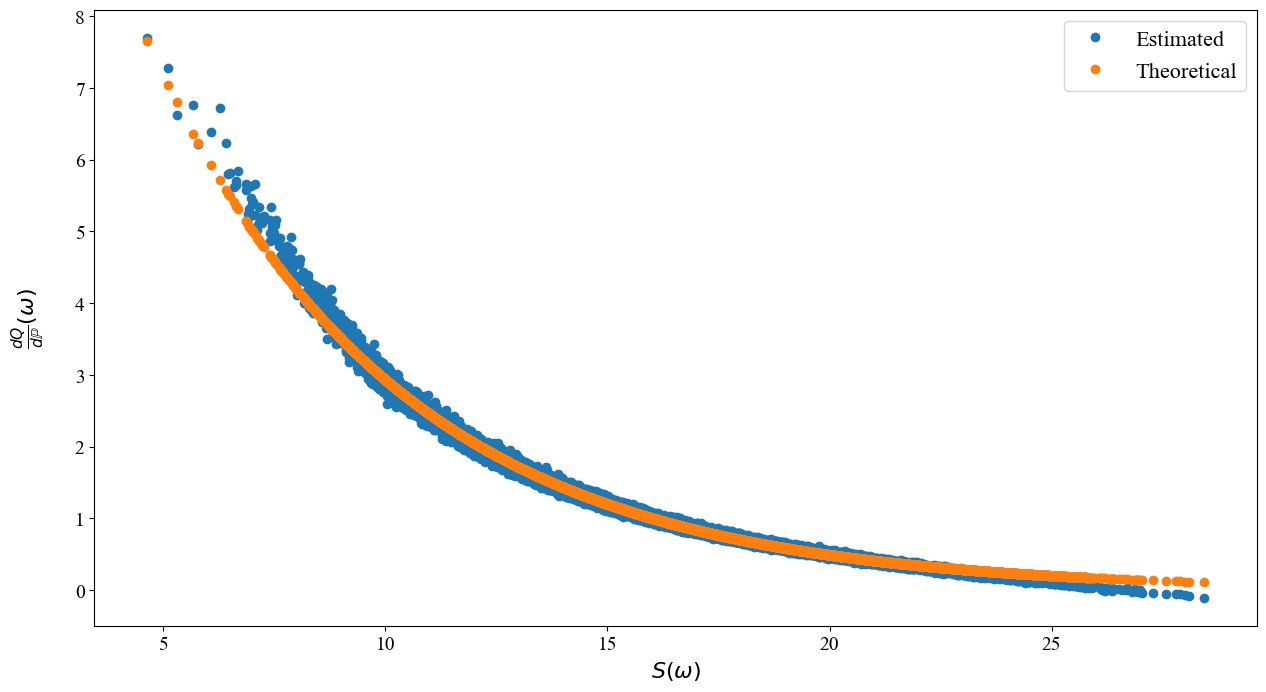

In [21]:
# Plot the predictions for the training dataset
plt.figure(figsize=(15, 8)) 
plt.plot(S_train_np, dQ_dP_train_pred_np, 'o', label='Estimated')
plt.plot(S_train_np, dQ_dP_train_np, 'o', label='Theoretical')
plt.xlabel(r'$S(\omega)$', fontsize=16)
plt.ylabel(r'$\frac{dQ}{d\mathbb{P}}(\omega)$', labelpad=20, fontsize=16)
plt.legend(fontsize=16)
plt.savefig('fig/norm_dQ_dP_train.png')
plt.show()

In [22]:
# Compute the ORD of the predictions for the training dataset
dQ_dP_train_abs = tf.math.abs(dQ_dP_train_pred - dQ_dP_train_theo)
mean_dQ_dP_train_ORD_L1 = tf.reduce_mean(dQ_dP_train_abs) / tf.reduce_mean(tf.math.abs(dQ_dP_train_theo))
print(f'The ORD of estimated Radon-Nikodym derivative on the training data: {mean_dQ_dP_train_ORD_L1.numpy()}')

The ORD of estimated Radon-Nikodym derivative on the training data: 0.02657041698694229


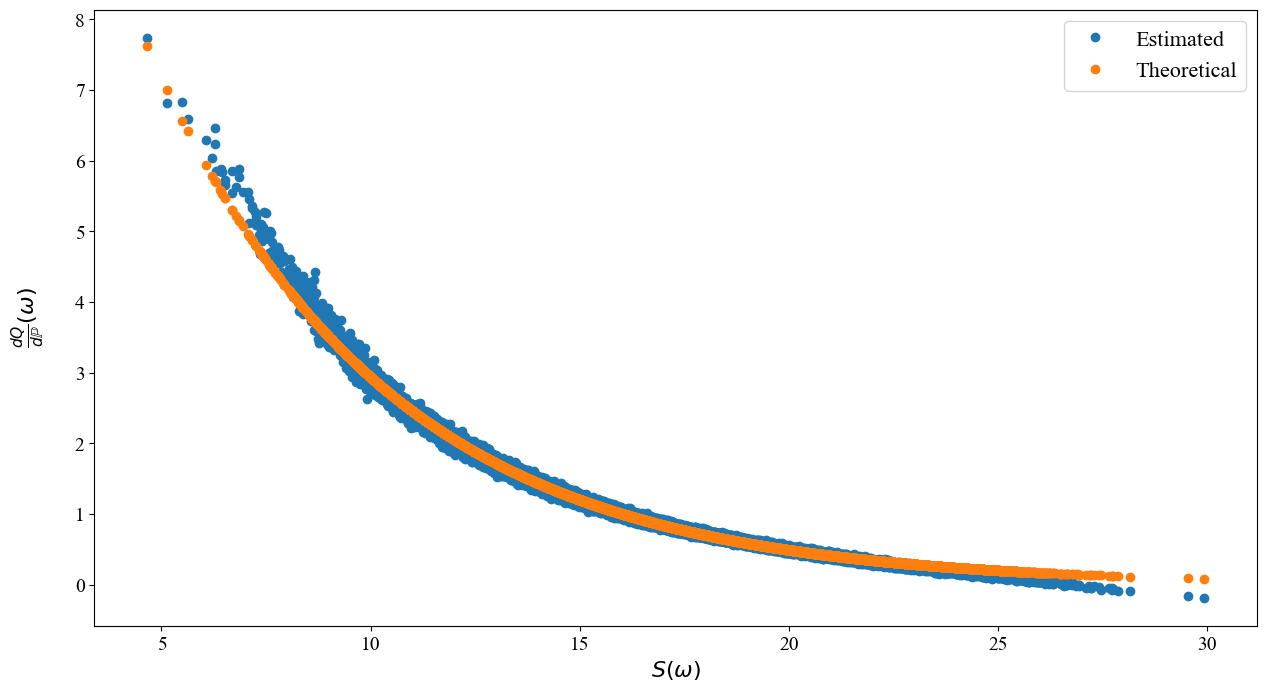

In [23]:
# Plot the predictions for the training dataset
plt.figure(figsize=(15, 8)) 
plt.plot(S_test_np, dQ_dP_test_pred_np, 'o', label='Estimated')
plt.plot(S_test_np, dQ_dP_test_np, 'o', label='Theoretical')
plt.xlabel(r'$S(\omega)$', fontsize=16)
plt.ylabel(r'$\frac{dQ}{d\mathbb{P}}(\omega)$', labelpad=20, fontsize=16)
plt.legend(fontsize=16)
plt.savefig('fig/norm_dQ_dP_test.png')
plt.show()

In [24]:
# Compute the ORD of the predictions for the test dataset
dQ_dP_test_abs = tf.math.abs(dQ_dP_test_pred - dQ_dP_test_theo)
mean_dQ_dP_test_ORD_L1 = tf.reduce_mean(dQ_dP_test_abs) / tf.reduce_mean(tf.math.abs(dQ_dP_test_theo))
print(f'The ORD of estimated Radon-Nikodym derivative on the test data: {mean_dQ_dP_test_ORD_L1.numpy()}')

The ORD of estimated Radon-Nikodym derivative on the test data: 0.027019457891583443


## Primal problem

Objective function for the deep learning task specified by Feng et al. (2022):
$$
J_\text{primal}(\varphi) := \sum_{i}\varphi_i(\textbf{X}) + \mu \cdot \text{Var}\bigg(\sum_i\varphi_i(\textbf{X})\bigg) + \lambda \cdot \bigg(B- \mathbb{E}\bigg[\sum_{n=1}^N u_n(X^n+Y^n)\bigg]\bigg)^+
$$
with hyperparameters $\mu$ and $\lambda$, the optimization problem becomes
$$
\tilde \rho(\textbf{X}) = \inf_{w,b} J_\text{primal}(\varphi) 
$$
where $\varphi: \mathbb{R}^N \rightarrow \mathbb{R}^N$  fully connected neural networks with parameters $(w, b)$, weights and biases respectively. $\mathbf{X}(\omega) \in \mathbb{R}^N$ is the risk factor and $\mathbf{Y}(\omega) \in \mathbb{R}^N$ is the cash allocation with $\mathbf{Y} := (Y^1,\dots,Y^N) = (\varphi_1(\mathbf{X}), \dots, \varphi_N(\mathbf{X})) =: \varphi(\mathbf{X})$.

In [25]:
# Define parameters for the penalties in the primal problem
mu = tf.constant(10, dtype=tf.float32)
lambda_val = tf.constant(10, dtype=tf.float32)

hidden_shape = 128

In [26]:
# Neural network architecture for the primal problem
def phi(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Dense(hidden_shape, activation='leaky_relu')(inputs)
    for i in range(layers):
        x = tf.keras.layers.Dense(hidden_shape, activation='leaky_relu')(x)
    x = tf.keras.layers.Dense(N, activation='linear')(x)
    stacked_output = tf.concat([inputs, x], axis=-1)
    model = tf.keras.Model(inputs=inputs, outputs=stacked_output)
    return model

In [27]:
# Define the objective function in the primal problem
def J_primal_loss(y_true, y_pred):
    x_input, y_output = tf.split(y_pred, [N, N], axis=-1)

    sum_y = tf.math.reduce_sum(y_output, axis=-1)
    first_term = tf.math.reduce_mean(sum_y, axis=0, keepdims=False)

    std_y = tf.math.reduce_std(sum_y, axis=0, keepdims=False)
    var_y = tf.math.square(std_y)
    mu_penalty = mu * var_y

    utlity_term = exponential_utility_tf(x_input + y_output, alpha_n)
    utlity_term = tf.math.reduce_sum(utlity_term, axis=-1)
    utlity_term = tf.math.reduce_mean(utlity_term, axis=0, keepdims=False)
    utlity_term = B - utlity_term
    utlity_term = tf.maximum(utlity_term, 0)
    utlity_term = lambda_val * utlity_term

    loss = first_term + mu_penalty + utlity_term

    return loss

In [28]:
# Time the training
start_time = time.time()

# Train the neural network for the primal problem
model = phi(model_shape)
model.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.0002), loss=J_primal_loss)
model.fit(X_train, tf.concat([X_train , y_train], axis=-1), epochs=epochs, batch_size=batch_size, verbose=0)

# Compute the loss over epochs
loss_primal = model.history.history['loss']

# Store the training time
elapsed_time_primal = (time.time() - start_time)/60
print(f"Elapsed time: {elapsed_time_primal} minutes")

Elapsed time: 2.907817530632019 minutes


In [29]:
# Compute the predictions for the training dataset
y_train_pred = model.predict(X_train, verbose=0)
X_train_pred, y_train_pred = tf.split(y_train_pred, [N, N], axis=-1)
model.evaluate(X_train, tf.concat([X_train , y_train], axis=-1), verbose=0)

-5.960106372833252

In [30]:
# Compute the predictions for the test dataset
y_test_pred = model.predict(X_test, verbose=0)
X_test_pred, y_test_pred = tf.split(y_test_pred, [N, N], axis=-1)
model.evaluate(X_test, tf.concat([X_test , y_test], axis=-1), verbose=0)

-5.978231906890869

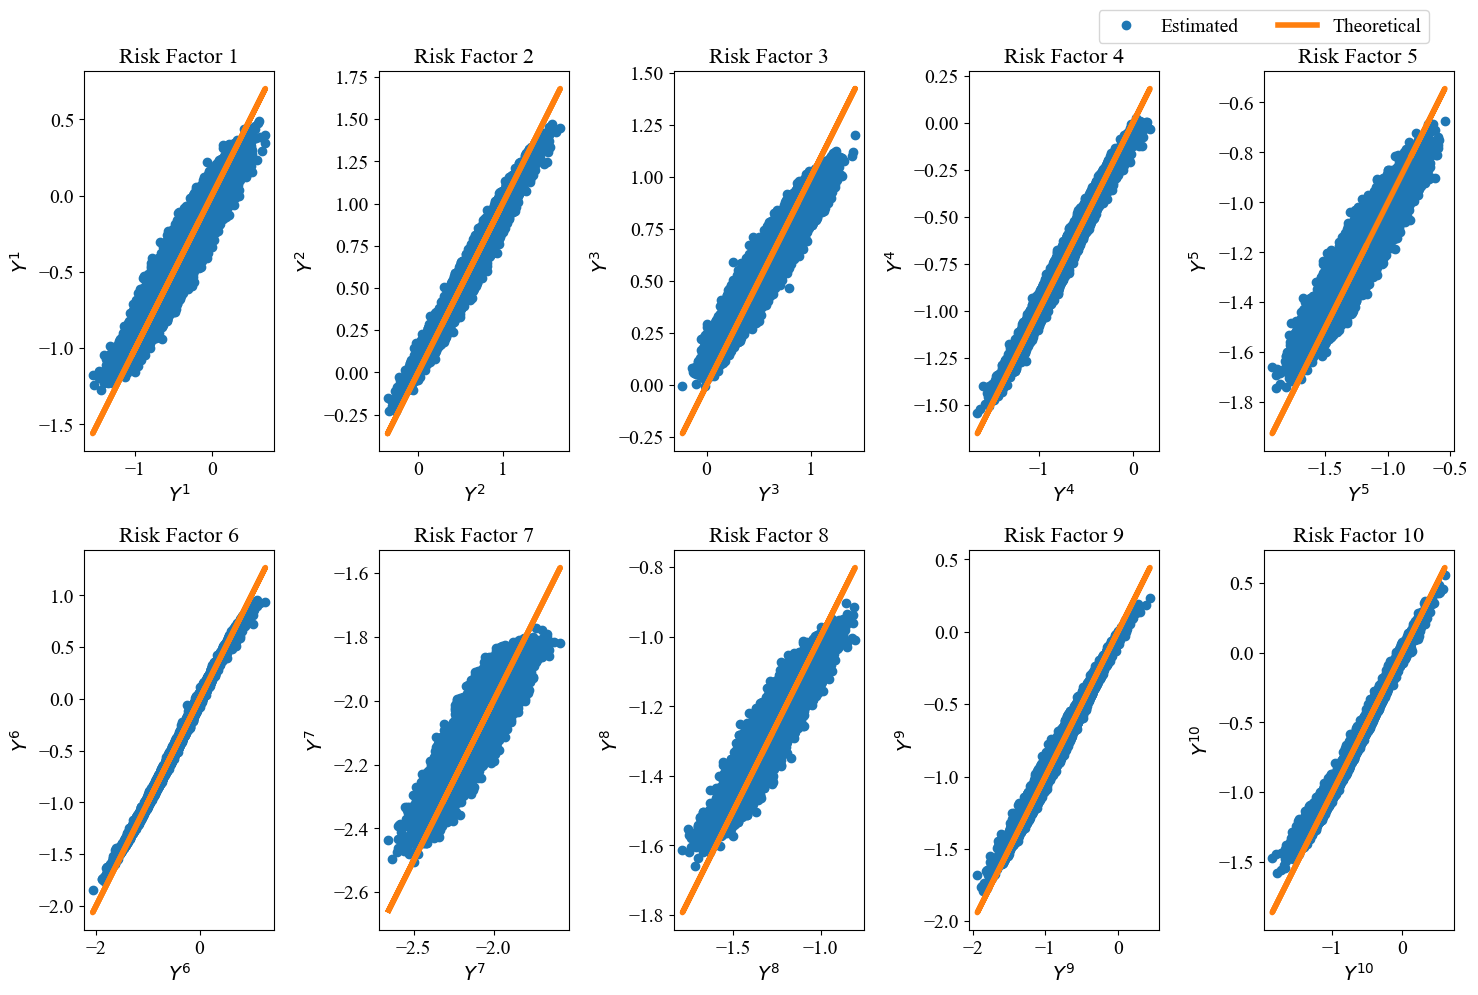

In [31]:
# Plot the solution to the primal problem for the training dataset
plt.figure(figsize=(15, 10)) 
for i in range(N):
    plt.subplot(2, 5, i+1)
    plt.plot(y_train[:,i], y_train_pred[:,i], 'o', label='Estimated')
    plt.plot(y_train[:,i], y_train[:,i], linewidth=4, label='Theoretical')
    plt.xlabel(r'$Y^{{{}}}$'.format(i+1))
    plt.ylabel(r'$Y^{{{}}}$'.format(i+1), labelpad=5)
    plt.title(r'Risk Factor {}'.format(i+1), fontsize=16)

plt.suptitle('', fontsize=16)
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0, 2.45), ncol=2)
plt.savefig('fig/norm_Y_train.png')
plt.show()

In [32]:
# Compute the ORD and absolute difference of the predictions for the training dataset
E_Y_train_pred = tf.reduce_mean(y_train_pred, axis=0)
E_Y_train = tf.reduce_mean(y_test, axis=0)
E_Y_train_abs = tf.math.abs(E_Y_train_pred - E_Y_train)
E_Y_train_ORD = tf.sqrt(tf.math.square(E_Y_train_pred - E_Y_train))/ tf.math.sqrt(tf.math.square(E_Y_train))

E_Y_train_res = {
    'Estimated': E_Y_train_pred.numpy().tolist() + [tf.reduce_mean(E_Y_train_pred, axis=-1).numpy()],
    'Theoretical': E_Y_train.numpy().tolist() + [tf.reduce_mean(E_Y_train, axis=-1).numpy()],
    'Absolute Difference': E_Y_train_abs.numpy().tolist() + [tf.reduce_mean(E_Y_train_abs, axis=-1).numpy()],
    'Overall Relative Difference (ORD)': E_Y_train_ORD.numpy().tolist() + [tf.reduce_mean(E_Y_train_ORD, axis=-1).numpy()]
}

E_Y_train_res = pd.DataFrame(E_Y_train_res).transpose()
E_Y_train_res.columns = [1,2,3,4,5,6,7,8,9,10,'Mean']
E_Y_train_res.to_csv('out/norm_E_Y_train_res.csv', index=True)
E_Y_train_res.round(4)

,1,2,3,4,5,6,7,8,9,10,Mean
Estimated,-0.4373,0.6147,0.6028,-0.7098,-1.2132,-0.4135,-2.1000,-1.2729,-0.7805,-0.6035,-0.6313
Theoretical,-0.4456,0.6187,0.6083,-0.7151,-1.2305,-0.4167,-2.1252,-1.2879,-0.7892,-0.6165,-0.6400
Absolute Difference,0.0083,0.0039,0.0054,0.0054,0.0174,0.0032,0.0252,0.0149,0.0087,0.0131,0.0106
Overall Relative Difference (ORD),0.0187,0.0064,0.0090,0.0075,0.0141,0.0077,0.0119,0.0116,0.0110,0.0212,0.0119


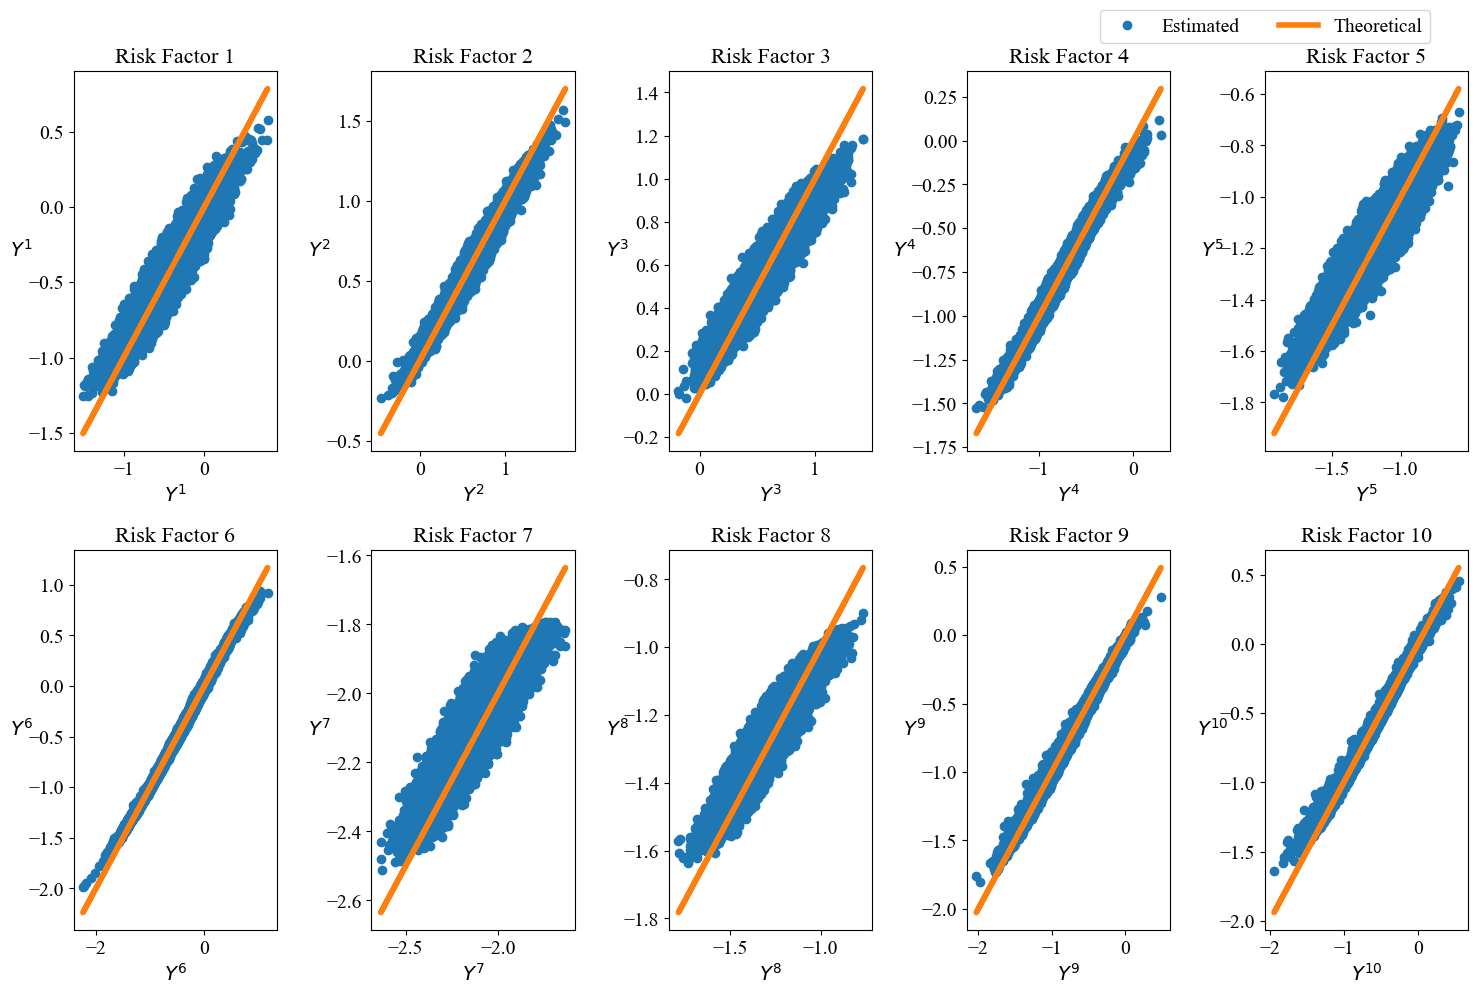

In [33]:
# Plot the solution to the primal problem for the test dataset
plt.figure(figsize=(15, 10)) 
for i in range(N):
    plt.subplot(2, 5, i+1)
    plt.plot(y_test[:,i], y_test_pred[:,i], 'o', label='Estimated')
    plt.plot(y_test[:,i], y_test[:,i], linewidth=4, label='Theoretical')
    plt.xlabel(r'$Y^{{{}}}$'.format(i+1))
    plt.ylabel(r'$Y^{{{}}}$'.format(i+1), rotation=0, labelpad=5)
    plt.title(r'Risk Factor {}'.format(i+1), fontsize=16)

plt.suptitle('', fontsize=16)
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0, 2.45), ncol=2)
plt.savefig('fig/norm_Y_test.png')
plt.show()

In [34]:
# Compute the ORD and absolute difference of the predictions for the test dataset
E_Y_test_pred = tf.reduce_mean(y_test_pred, axis=0)
E_Y_test = tf.reduce_mean(y_test, axis=0)
E_Y_test_abs = tf.math.abs(E_Y_test_pred - E_Y_test)
E_Y_test_ORD = tf.sqrt(tf.math.square(E_Y_test_pred - E_Y_test))/ tf.math.sqrt(tf.math.square(E_Y_test))

E_Y_test_res = {
    'Estimated': E_Y_test_pred.numpy().tolist() + [tf.reduce_mean(E_Y_test_pred, axis=-1).numpy()],
    'Theoretical': E_Y_test.numpy().tolist() + [tf.reduce_mean(E_Y_test, axis=-1).numpy()],
    'Absolute Difference': E_Y_test_abs.numpy().tolist() + [tf.reduce_mean(E_Y_test_abs, axis=-1).numpy()],
    'Overall Relative Difference (ORD)': E_Y_test_ORD.numpy().tolist() + [tf.reduce_mean(E_Y_test_ORD, axis=-1).numpy()]
}

E_Y_test_res = pd.DataFrame(E_Y_test_res).transpose()
E_Y_test_res.columns = [1,2,3,4,5,6,7,8,9,10,'Mean']
E_Y_test_res.to_csv('out/norm_E_Y_test_res.csv', index=True)
E_Y_test_res.round(4)

,1,2,3,4,5,6,7,8,9,10,Mean
Estimated,-0.4370,0.6147,0.6037,-0.7087,-1.2142,-0.4128,-2.1000,-1.2726,-0.7819,-0.6048,-0.6313
Theoretical,-0.4456,0.6187,0.6083,-0.7151,-1.2305,-0.4167,-2.1252,-1.2879,-0.7892,-0.6165,-0.6400
Absolute Difference,0.0086,0.0040,0.0045,0.0064,0.0164,0.0039,0.0252,0.0153,0.0073,0.0117,0.0103
Overall Relative Difference (ORD),0.0194,0.0064,0.0074,0.0090,0.0133,0.0094,0.0119,0.0119,0.0092,0.0190,0.0117


## Combined solution

The optimal fair individual risk allocation is determined by the following formula:
$$
\rho^n(\mathbf{X})=\mathbb{E}_Q[Y^n]=\mathbb{E}\bigg[Y^n \cdot \frac{dQ}{d\mathbb{P}}\bigg]
$$
To achieve this, the solutions of both the primal and dual problems must be integrated.

In [35]:
# Compute the training time
training_time = {'Training Time (minutes)': [elapsed_time_primal, elapsed_time_dual, elapsed_time_primal + elapsed_time_dual]}
training_time = pd.DataFrame(training_time).transpose()
training_time.columns = ['Primal Problem', 'Dual Problem', 'Total']
training_time.to_csv('out/norm_training_time.csv', index=True)
training_time

,Primal Problem,Dual Problem,Total
Training Time (minutes),2.907818,5.625329,8.533146


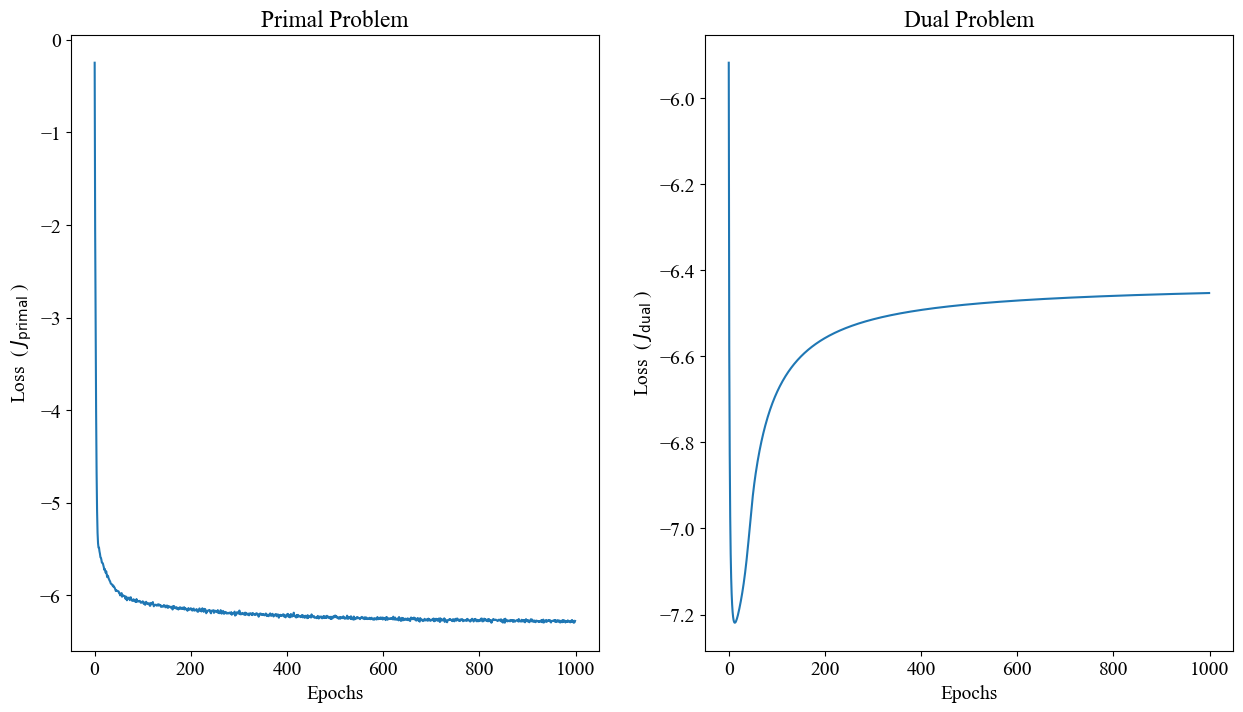

In [36]:
# Plot the loss over epochs for the primal and dual problems
plt.figure(figsize=(15, 8)) 

plt.subplot(1, 2, 1)
plt.plot(range(epochs), loss_primal)
plt.xlabel('Epochs')
plt.ylabel(r'Loss  ( $J_\text{primal}$ )')
plt.title('Primal Problem')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss_dual)
plt.xlabel('Epochs')
plt.ylabel(r'Loss  ( $J_\text{dual}$ )')
plt.title('Dual Problem')

plt.savefig('fig/norm_loss_epochs.png')
plt.show()

In [37]:
# Compute the ORD and absolute difference of the combined solution for the training dataset
Q_Y_train_pred = y_train_pred * dQ_dP_train_pred
EQ_Y_train_pred = tf.reduce_mean(Q_Y_train_pred, axis=0)

Q_Y_train_theo = y_train * dQ_dP_train_theo
EQ_Y_train = tf.reduce_mean(Q_Y_train_theo, axis=0)

EQ_Y_train_abs = tf.math.abs(EQ_Y_train_pred - EQ_Y_train)
EQ_Y_train_ORD_L1 = tf.math.abs(EQ_Y_train_abs) / tf.math.abs(EQ_Y_train)
EQ_Y_train_ORD_L2 = tf.sqrt(tf.math.square(EQ_Y_train_pred - EQ_Y_train)) / tf.math.sqrt(tf.math.square(EQ_Y_train))

mean_EQ_Y_train_abs = tf.reduce_mean(tf.math.abs(EQ_Y_train_abs))
mean_EQ_Y_train_ORD_L1 = mean_EQ_Y_train_abs / tf.reduce_mean(tf.math.abs(EQ_Y_train))
mean_EQ_Y_train_ORD_L2 = tf.reduce_mean(tf.sqrt(tf.math.square(EQ_Y_train_pred - EQ_Y_train))) / tf.reduce_mean(tf.math.sqrt(tf.math.square(EQ_Y_train)))

EQ_Y_train_res = {
    'Estimated': EQ_Y_train_pred.numpy().tolist() + [tf.reduce_mean(EQ_Y_train_pred, axis=-1).numpy()],
    'Theoretical': EQ_Y_train.numpy().tolist() + [tf.reduce_mean(EQ_Y_train, axis=-1).numpy()],
    'Absolute Difference': EQ_Y_train_abs.numpy().tolist() + [mean_EQ_Y_train_abs.numpy()],
    'Overall Relative Difference (ORD)': EQ_Y_train_ORD_L1.numpy().tolist() + [mean_EQ_Y_train_ORD_L1.numpy()]
}

EQ_Y_train_res = pd.DataFrame(EQ_Y_train_res).transpose()
EQ_Y_train_res.columns = [1,2,3,4,5,6,7,8,9,10,'Mean']
EQ_Y_train_res.to_csv('out/norm_EQ_Y_train_res.csv', index=True)
EQ_Y_train_res.round(4)

,1,2,3,4,5,6,7,8,9,10,Mean
Estimated,-0.5587,0.6723,0.5652,-0.8271,-1.2110,-0.2738,-2.1524,-1.3253,-0.6914,-0.4983,-0.6301
Theoretical,-0.5687,0.6733,0.5654,-0.8349,-1.2260,-0.2783,-2.1764,-1.3395,-0.6983,-0.5098,-0.6393
Absolute Difference,0.0101,0.0011,0.0002,0.0078,0.0149,0.0045,0.0241,0.0141,0.0069,0.0115,0.0095
Overall Relative Difference (ORD),0.0177,0.0016,0.0003,0.0093,0.0122,0.0163,0.0111,0.0106,0.0099,0.0225,0.0107


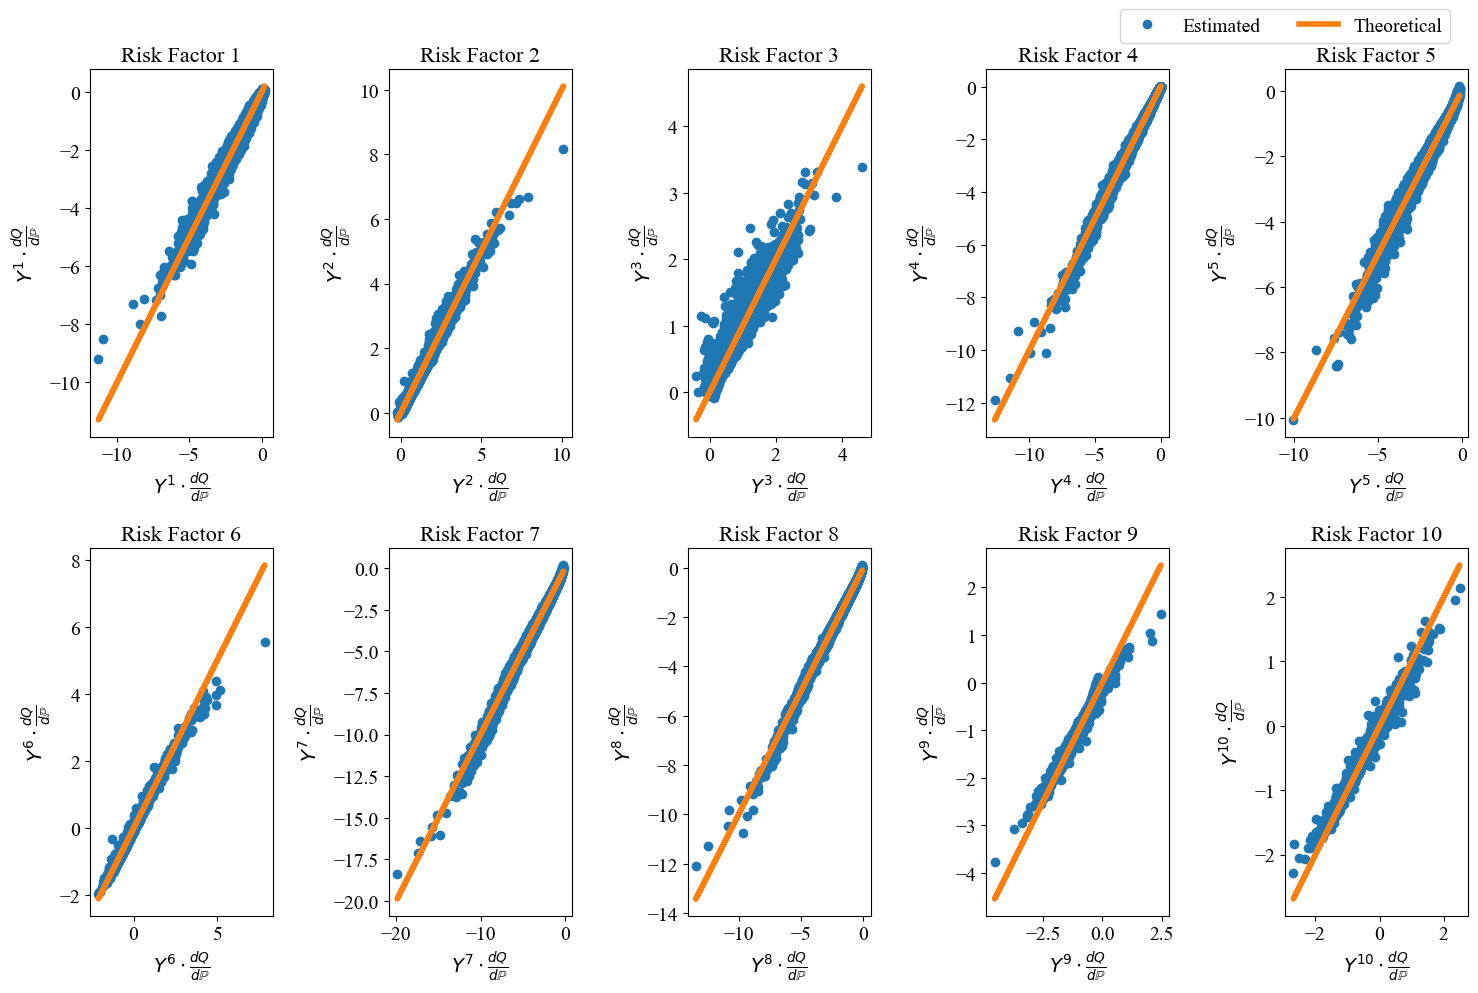

In [38]:
# Plot the combined solution for the training dataset
plt.figure(figsize=(15, 10)) 
for i in range(N):
    plt.subplot(2, 5, i+1)
    plt.plot(Q_Y_train_theo[:,i], Q_Y_train_pred[:,i], 'o', label='Estimated')
    plt.plot(Q_Y_train_theo[:,i], Q_Y_train_theo[:,i], linewidth=4, label='Theoretical')
    plt.xlabel(r'$Y^{{{}}} \cdot \frac{{dQ}}{{d\mathbb{{P}}}}$'.format(i+1))
    plt.ylabel(r'$Y^{{{}}} \cdot \frac{{dQ}}{{d\mathbb{{P}}}}$'.format(i+1))
    plt.title(r'Risk Factor {}'.format(i+1), fontsize=16)

plt.suptitle('', fontsize=16)
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0, 2.495), ncol=2)
plt.savefig('fig/norm_QY_train.png')
plt.show()

In [39]:
# Compute the values of the objective functions for the training dataset
rho_train_emp = tf.reduce_sum(EQ_Y_train_pred, axis=-1)
rho_train_theo = rho_dual_problem(X_train, alpha_n, B)
rho_train_abs = tf.math.abs(rho_train_emp - rho_train_theo)
rho_train_ord = tf.sqrt(tf.math.square(rho_train_emp - rho_train_theo))/ tf.math.sqrt(tf.math.square(rho_train_theo))

aplha_B_train_emp = tf.constant(-aplha_B_train_emp, dtype=tf.float32)
aplha_B_train_theo = alpha_B_dual_problem(X_train, alpha_n, B)
aplha_B_train_abs = tf.math.abs(aplha_B_train_emp - aplha_B_train_theo)
aplha_B_train_ord_L1 = tf.math.abs(aplha_B_train_emp - aplha_B_train_theo) /  tf.math.abs(aplha_B_train_theo)
aplha_B_train_ord_L2 = tf.sqrt(tf.math.square(aplha_B_train_emp - aplha_B_train_theo))/ tf.math.sqrt(tf.math.square(aplha_B_train_theo))

obj_train_res = {
    'rho': [rho_train_emp.numpy(), rho_train_theo.numpy().item(), rho_train_abs.numpy().item(), rho_train_ord.numpy().item()],
    'alpha_B': [aplha_B_train_emp.numpy().item(), aplha_B_train_theo.numpy().item(), aplha_B_train_abs.numpy().item(), aplha_B_train_ord_L1.numpy().item()]
}

obj_train_res_out = pd.DataFrame(obj_train_res)
obj_train_res_out.index = ['Estimated', 'Theoretical', 'Absolute Difference', 'Overall Relative Difference (ORD)']
obj_train_res_out.to_csv('out/norm_obj_train_res_out.csv', index=True)
obj_train_res_out.round(4)

,rho,alpha_B
Estimated,-6.3005,-8.8063
Theoretical,-6.3932,-8.8458
Absolute Difference,0.0927,0.0395
Overall Relative Difference (ORD),0.0145,0.0045


In [40]:
# Compute the ORD and absolute difference of the combined solution for the test dataset
Q_Y_test_pred = y_test_pred * dQ_dP_test_pred
EQ_Y_test_pred = tf.reduce_mean(Q_Y_test_pred, axis=0)

Q_Y_test_theo = y_test * dQ_dP_test_theo
EQ_Y_test = tf.reduce_mean(Q_Y_test_theo, axis=0)

EQ_Y_test_abs = tf.math.abs(EQ_Y_test_pred - EQ_Y_test)
EQ_Y_test_ORD_L1 = tf.math.abs(EQ_Y_test_abs) / tf.math.abs(EQ_Y_train)
EQ_Y_test_ORD_L2 = tf.sqrt(tf.math.square(EQ_Y_test_pred - EQ_Y_train)) / tf.math.sqrt(tf.math.square(EQ_Y_test))

mean_EQ_Y_test_abs = tf.reduce_mean(tf.math.abs(EQ_Y_test_abs))
mean_EQ_Y_test_ORD_L1 = mean_EQ_Y_test_abs / tf.reduce_mean(tf.math.abs(EQ_Y_test))
mean_EQ_Y_test_ORD_L2 = tf.reduce_mean(tf.sqrt(tf.math.square(EQ_Y_test_pred - EQ_Y_test))) / tf.reduce_mean(tf.math.sqrt(tf.math.square(EQ_Y_test)))

EQ_Y_test_res = {
    'Estimated': EQ_Y_test_pred.numpy().tolist() + [tf.reduce_mean(EQ_Y_test_pred, axis=-1).numpy()],
    'Theoretical': EQ_Y_test.numpy().tolist() + [tf.reduce_mean(EQ_Y_test, axis=-1).numpy()],
    'Absolute Difference': EQ_Y_test_abs.numpy().tolist() + [mean_EQ_Y_test_abs.numpy()],
    'Overall Relative Difference (ORD)': EQ_Y_test_ORD_L1.numpy().tolist() + [mean_EQ_Y_test_ORD_L1.numpy()]
}

EQ_Y_test_res = pd.DataFrame(EQ_Y_test_res).transpose()
EQ_Y_test_res.columns = [1,2,3,4,5,6,7,8,9,10,'Mean']
EQ_Y_test_res.to_csv('out/norm_EQ_Y_test_res.csv', index=True)
EQ_Y_test_res.round(4)

,1,2,3,4,5,6,7,8,9,10,Mean
Estimated,-0.5594,0.6728,0.5663,-0.8274,-1.2113,-0.2728,-2.1530,-1.3256,-0.6919,-0.4986,-0.6301
Theoretical,-0.5712,0.6728,0.5667,-0.8359,-1.2273,-0.2783,-2.1771,-1.3400,-0.6991,-0.5105,-0.6400
Absolute Difference,0.0118,0.0000,0.0004,0.0084,0.0160,0.0055,0.0241,0.0144,0.0072,0.0119,0.0100
Overall Relative Difference (ORD),0.0208,0.0000,0.0007,0.0101,0.0130,0.0198,0.0111,0.0107,0.0103,0.0234,0.0112


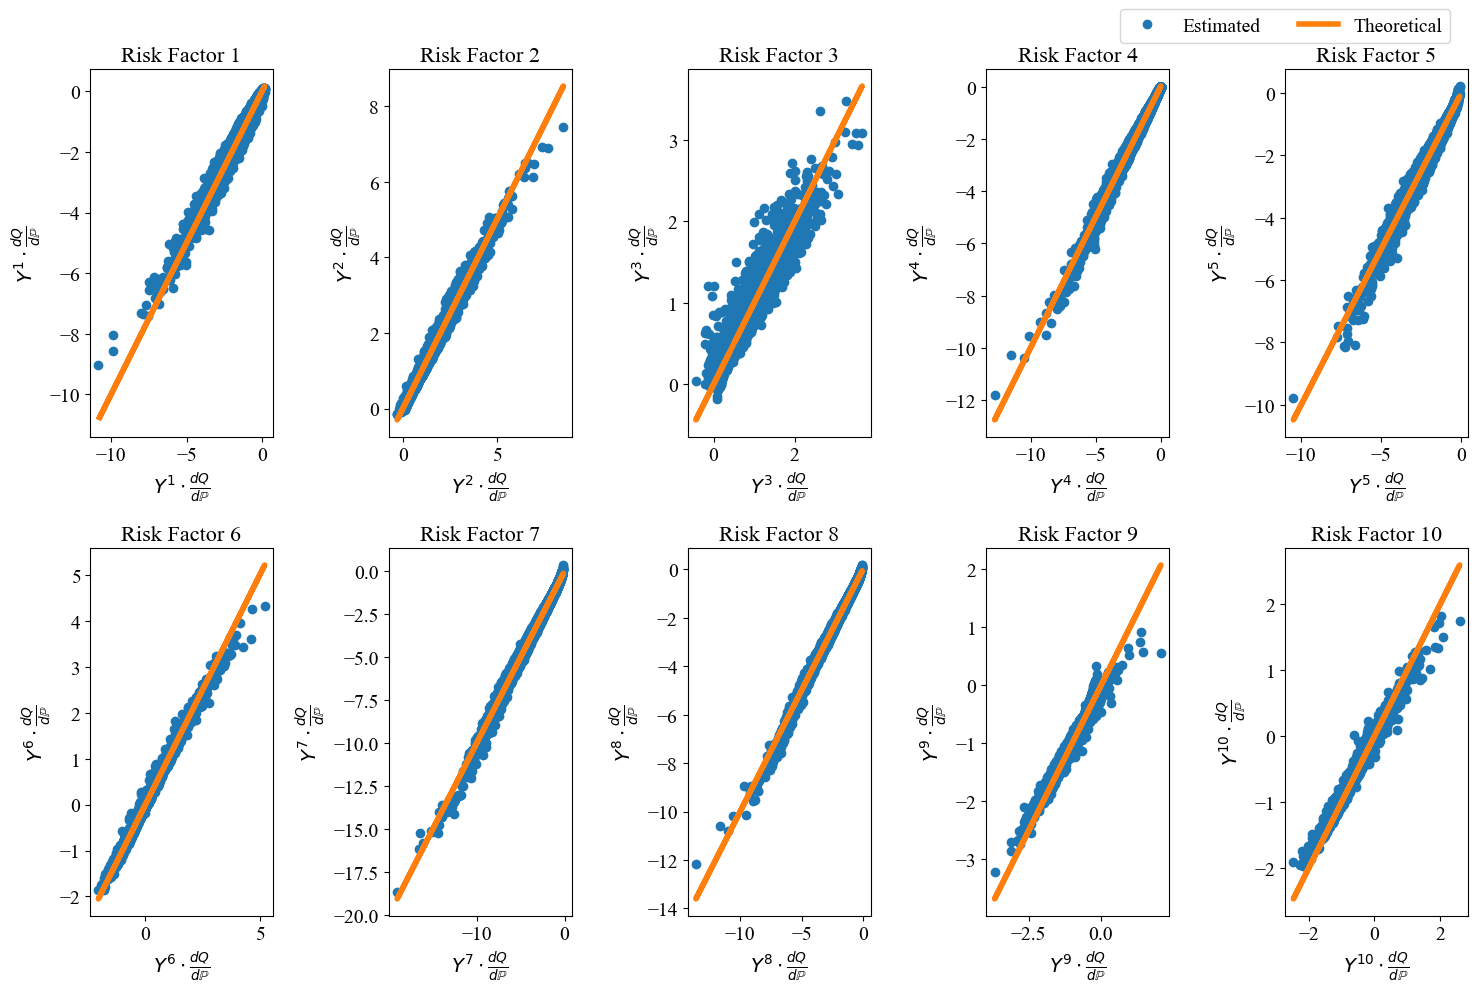

In [41]:
# Plot the combined solution for the test dataset
plt.figure(figsize=(15, 10)) 
for i in range(N):
    plt.subplot(2, 5, i+1)
    plt.plot(Q_Y_test_theo[:,i], Q_Y_test_pred[:,i], 'o', label='Estimated')
    plt.plot(Q_Y_test_theo[:,i], Q_Y_test_theo[:,i], linewidth=4, label='Theoretical')
    plt.xlabel(r'$Y^{{{}}} \cdot \frac{{dQ}}{{d\mathbb{{P}}}}$'.format(i+1))
    plt.ylabel(r'$Y^{{{}}} \cdot \frac{{dQ}}{{d\mathbb{{P}}}}$'.format(i+1))
    plt.title(r'Risk Factor {}'.format(i+1), fontsize=16)

plt.suptitle('', fontsize=16)
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0, 2.495), ncol=2)
plt.savefig('fig/norm_QY_test.png')
plt.show()

In [42]:
# Compute the values of the objective functions for the test dataset
rho_test_emp = tf.reduce_sum(EQ_Y_test_pred, axis=-1)
rho_test_theo = rho_dual_problem(X_test, alpha_n, B)
rho_test_abs = tf.math.abs(rho_test_emp - rho_test_theo)
rho_test_ord = tf.sqrt(tf.math.square(rho_test_emp - rho_test_theo))/ tf.math.sqrt(tf.math.square(rho_test_theo))

aplha_B_test_emp = tf.constant(-aplha_B_test_emp, dtype=tf.float32)
aplha_B_test_theo = alpha_B_dual_problem(X_test, alpha_n, B)
aplha_B_test_abs = tf.math.abs(aplha_B_test_emp - aplha_B_test_theo)
aplha_B_test_ord_L1 = tf.math.abs(aplha_B_test_emp - aplha_B_test_theo) /  tf.math.abs(aplha_B_test_theo)
aplha_B_test_ord_L2 = tf.sqrt(tf.math.square(aplha_B_test_emp - aplha_B_test_theo))/ tf.math.sqrt(tf.math.square(aplha_B_test_theo))

obj_test_res = {
    'rho': [rho_test_emp.numpy(), rho_test_theo.numpy().item(), rho_test_abs.numpy().item(), rho_test_ord.numpy().item()],
    'alpha_B': [aplha_B_test_emp.numpy().item(), aplha_B_test_theo.numpy().item(), aplha_B_test_abs.numpy().item(), aplha_B_test_ord_L1.numpy().item()]
}

obj_test_res_out = pd.DataFrame(obj_test_res)
obj_test_res_out.index = ['Estimated', 'Theoretical', 'Absolute Difference', 'Overall Relative Difference (ORD)']
obj_test_res_out.to_csv('out/norm_obj_test_res_out.csv', index=True)
obj_test_res_out.round(4)

,rho,alpha_B
Estimated,-6.3009,-8.7969
Theoretical,-6.3998,-8.8382
Absolute Difference,0.0989,0.0412
Overall Relative Difference (ORD),0.0155,0.0047


## References

Feng, Y., Min, M., & Jean-Pierre, F. (2022). Deep learning for systemic risk measures. arXiv.org. https://doi.org/10.48550/arxiv.2207.00739